# Reconnaissance d'objets par IA

Ce Notebook contient le code destiné à la reconnaissance d'objets par le robot.


L'objectif est d'entraîner le robot à reconnaître les objets (obstacles) qui l'entourent afin qu'il puisse avoir une idée de la taille de l'objet à contourner. En effet, en voyant les obstacles, et en les reconnaissant, il aurait une approximation du volume occupé par l’obstacle (en termes de profondeur).

--> Cela pourra éventuellement servir pour améliorer la planification de trajectoire (objet d'un autre Notebook) du robot.


Pour réaliser cet objectif, la démarche proposée est de :
- 1. Utiliser un classifieur entraîné à reconnaître les images des objets/ obstacles susceptibles d'être rencontrées par le robot
- 2. Utiliser une table de correspondance entre l'objet et ses dimensions "classiques" afin de donner au robot une idée de la taille de l'obstacle qu'il peut observer

--> Données à utiliser : images caméras

Nous détaillons dans ce notebook essentiellement la 1ère étape de cette démarche proposée.

In [ ]:
# Imports 

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, layers
from keras.applications.resnet_v2 import preprocess_input

Lien ResNet TensorFlow : https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50


Preprocessing of inputs : https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input


In [ ]:
# Chargement du réseau ResNet, pré-entraîné sur ImageNet

model = keras.Sequential(name="ResNetClassifier")
model.add(applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
))

#model.add(layers.Dense(15, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model.summary()

102875136/102869336 [==============================] - 3s 0us/step
Model: "ResNetClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 1000)              25613800  
Total params: 25,613,800
Trainable params: 25,568,360
Non-trainable params: 45,440
_________________________________________________________________


On peut tester ce classifieur sur quelques images :

In [ ]:
# Import des images
from google.colab import files
files.upload()

Saving Image chien.jpg to Image chien.jpg
Saving Image fauteuil.jpg to Image fauteuil.jpg
Saving Image table.jpg to Image table.jpg


{'Image chien.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x01h\x02\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xbb\xc9xk<w[\x0f\x11\x1b\x8f\x01\x9b\x8b\x11\xc6\xca\xcdF\xa9\x96\xabT\xcb\rU\x9a\x1afiZk4M"\x89O\x88\xb8u*\x0e\x88\xb1\xe4\x8b\x1f\x15\x07EEl]\x0c\x8b\x83)pdU\r\x00\x19LV9\xac\x15\x86v\xc5\x80cF\x009\xac\xa5Vk\xa9U\x9a\xe8\x81\xcdp\xa8a\x82\xa0\x1a\x0b\x

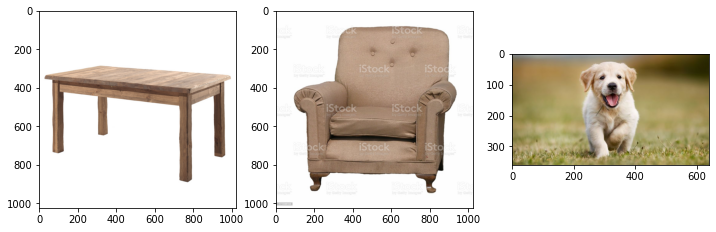

In [ ]:
# Affichages des images chargées :
import matplotlib.pyplot as plt

img1 = plt.imread('Image table.jpg')
img2 = plt.imread('Image fauteuil.jpg')
img3 = plt.imread('Image chien.jpg')

fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(img1)
fig.add_subplot(1, 3, 2)
plt.imshow(img2)
fig.add_subplot(1, 3, 3)
plt.imshow(img3)

plt.show()

In [ ]:
# Ouverture et redimensionnement des images :
from PIL import Image

im1 = Image.open('Image table.jpg').resize((224,224))
im2 = Image.open('Image fauteuil.jpg').resize((224,224))
im3 = Image.open('Image chien.jpg').resize((224,224))
print('Image chargée: format {}, dtype {}'.format(im1.mode, im1.size))
print('Image chargée: format {}, dtype {}'.format(im2.mode, im2.size))
print('Image chargée: format {}, dtype {}'.format(im3.mode, im3.size))

# Preprocessing des images avec la fonction dédiée du modèle ResNet :
x1 = tf.keras.applications.resnet_v2.preprocess_input(np.array(im1)[None, :], data_format=None)
x2 = tf.keras.applications.resnet_v2.preprocess_input(np.array(im2)[None, :], data_format=None)
x3 = tf.keras.applications.resnet_v2.preprocess_input(np.array(im3)[None, :], data_format=None)
print("Preprocessing ok")

# Prediction des images avec le modèle ResNet :
preds = np.concatenate((model(x1), model(x2), model(x3)), axis=0)
tf.keras.applications.resnet_v2.decode_predictions(preds, top=5)

Image chargée: format RGB, dtype (224, 224)
Image chargée: format RGB, dtype (224, 224)
Image chargée: format RGB, dtype (224, 224)
Preprocessing ok
40960/35363 [==================================] - 0s 0us/step


[[('n03201208', 'dining_table', 0.9260276),
  ('n03179701', 'desk', 0.068248406),
  ('n03903868', 'pedestal', 0.00349675),
  ('n03992509', "potter's_wheel", 0.00037316416),
  ('n03982430', 'pool_table', 0.00031425868)],
 [('n04429376', 'throne', 0.5273957),
  ('n04099969', 'rocking_chair', 0.35372302),
  ('n04344873', 'studio_couch', 0.04762899),
  ('n02791124', 'barber_chair', 0.04458012),
  ('n03376595', 'folding_chair', 0.004875748)],
 [('n02099601', 'golden_retriever', 0.74788433),
  ('n02111500', 'Great_Pyrenees', 0.15559942),
  ('n02099712', 'Labrador_retriever', 0.056293625),
  ('n02101556', 'clumber', 0.035724815),
  ('n02104029', 'kuvasz', 0.0039342237)]]

Les prédictions ci-dessus montrent les classes (correspondant ici aux catégories / types d'objets) prédites par le classifieur pour les 3 images prises en exemple. Pour chaque classe prédite, on lit également la probabilité d'appartenance à cette classe d'après le classifieur. On a affiché ici les 5 classes les plus probables, mais c'est donc la 1ère des 5 qui est la plus importante car c'est celle finalement prédite par le classifieur pour l'image considérée.

On observe donc qu'un tel classifieur pré-entraîné peut être relativement fiable par rapport aux images qui lui sont fournies. 

De plus, on pourra éventuellement ré-entraîné un tel classifieur si on le souhaite. Pour cela, on pourra partir des paramètres d'un classifieur pré-entraîné comme celui-ci, puis finetuner ses paramètres. Cela consiste à initialiser ses paramètres avec ceux du classifieur pré-entraîné puis à chercher à les améliorer par de légères modifications (avec un pas de gradient faible par exemple), en relançant l'entraînement sur des images auxquelles le robot sera amené à être véritablement confronté. Une autre solution consiste à rajouter une couche dense par dessus la couche de décision du réseau pré-entraîné, et à entraîner uniquement les paramètres correspondant à cette couche, en figeant les paramètres du réseau pré-entraîné. Le nombre de classes en sortie correspondra alors au nombre de neurones sur la couche dense de sortie, qui peut être pris par exemple inférieur au nombre de classes du réseau pré-entraîné, si la tâche à laquelle on prédestine le modèle est plus spécifique.

Ce type de procédé par finetuning peut permettre à un classifieur de profiter d'un apprentissage déjà effectué (sur un gros jeu de données) tout en le rendant ensuite encore plus adapaté à une tâche spécifique.

A partir d'un tel classifieur, on pourra ensuite établir une table de correspondance entre les classes prédites et les dimensions classiques des objets reconnus.